In [1]:
import numpy as np
import pandas as pd


from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder, Imputer, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_union, make_pipeline

%matplotlib inline

In [2]:
df_train = pd.read_csv("train.csv", parse_dates=["Date"], date_parser=pd.to_datetime, low_memory=False)
df_test = pd.read_csv("test.csv", parse_dates=["Date"], date_parser=pd.to_datetime, low_memory=False)
df_store = pd.read_csv("store.csv")

In [3]:
train = df_train.merge(df_store)
test = df_test.merge(df_store)

### EDA

In [4]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


The dataset contains following features (most of them are pretty self-descriptive, but anyway):  
- Store — store's id  
- DayOfWeek — day of week  
- Date — date  
- Sales — turnover on this day, target  
- Customers — a number of customers on this day  
- Open – indicates whether the store was open or closed on this day  
- Promo — indicates whether promo was active on this day  
- StateHoliday — indicates whether there was a state holiday on this day and its' kind  
- SchoolHoliday — indicates whether this day was a vacation day in public schools

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


Not a single null here

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


Important differences from the train:  
- **no Customers column**  
- some NaNs in the Open column  

These discrepancies should be dealt with during data preparation stage.

In [7]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


This dataset contains metadata for every store, such as:
- StoreType - describes a store type
- Assortment — describes an assortment level  
- CompetitionDistance — distance to the nearest competitor store  
- CompetitionOpenSinceYear — a year when the competitor store was opened  
- CompetitionOpenSinceMonth — a month when the competitor store was opened
- Promo2 — indicates whether there's a continuing and consecutive promotion in this store
- Promo2SinceYear — a year when the store started participating in Promo2
- Promo2SinceWeek — a calendar week when the store started participating in Promo2
- PromoInterval — a list of month when Promo2 is active

In [8]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


~30% of entries contain information about the distance to the nearest competitor, but, however, miss information about the nearest competititor opening date. It could mean that this competitor was here long before Rossmann or that opening date is just unknown.  
Also 3 entries lack any information about competition whatsoever, it may mean that this store is the only store in the area.
All other NaNs are related to Promo2 dates/intervals and perfectly explainable.

##### Dates

Since we a working with time series here, dates may be the most important thing there is.

In [9]:
print("train")
print("max: ", df_train.Date.min())
print("min:", df_train.Date.max())
print("delta: ", df_train.Date.max() - df_train.Date.min())

train
max:  2013-01-01 00:00:00
min: 2015-07-31 00:00:00
delta:  941 days 00:00:00


In [10]:
print("test")
print("max: ", df_test.Date.min())
print("min:", df_test.Date.max())
print("delta: ", df_test.Date.max() - df_test.Date.min())

test
max:  2015-08-01 00:00:00
min: 2015-09-17 00:00:00
delta:  47 days 00:00:00


Since test observations took place after train ones, it's possible to predict test sales using test ones.

##### Sales by day of week

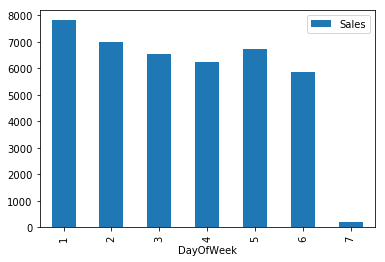

In [11]:
df_train.groupby("DayOfWeek").agg({"Sales": "mean"}).plot(kind="bar")

Sales dramatically drop on Sunday; it can hardly be organic, together with a slight increase of sales on Monday it may indicate that most stores are simply closed on Sunday.

In [12]:
df_train[(df_train.DayOfWeek == 7) & (df_train.Open == 1)].Store.unique().shape[0]

33

The assumption was correct, only 33 stores out of 1115 were opened on Sunday at least once.

##### Sales vs state holidays

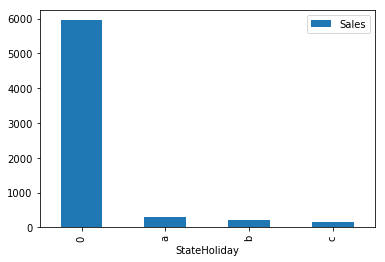

In [13]:
df_train.groupby("StateHoliday").agg({"Sales": "mean"}).plot(kind="bar")

And again, it may just mean that most of the stores are closed on holidays.

##### Sales vs school holidays

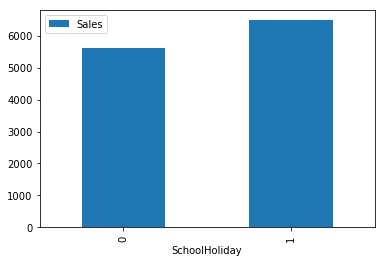

In [14]:
df_train.groupby("SchoolHoliday").agg({"Sales": "mean"}).plot(kind="bar")

There's a slight increase in sales during vacations in schools.

##### Sales vs Promo

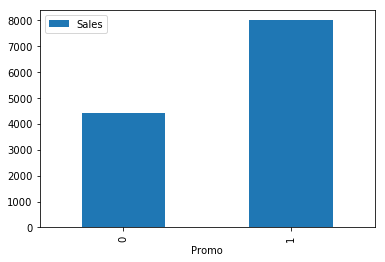

In [15]:
df_train.groupby("Promo").agg({"Sales": "mean"}).plot(kind="bar")

Promo increases mean daily sales almost two-fold.

Let's combine the sales data with the stores metadata, introduce some new features and take a look at them.

In [16]:
train = df_train.merge(df_store)
test = df_test.merge(df_store)

Two important features come to mind:
- Promo2Active — we have everything (participation status, date of start and schedule) to derive whether Promo2 is active for every day/store combination in dataset
- CompetitionActive — we have a date of competitor store opening, so we can derive whether competitor store is active for every day/store combination in dataset

In [17]:
train.PromoInterval.unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'], dtype=object)

In [18]:
def get_Promo2Active(df):
    months_map = {v:i+1 for i, v in enumerate(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                               "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"])}
    def is_Promo2_active(row):
        if row.Promo2 == 0:
            return 0
        
        current_week, current_month, current_year = row.Date.week, row.Date.month, row.Date.year
        start_week, start_year = row.Promo2SinceWeek, row.Promo2SinceYear
        active_months = set([months_map[m] for m in row.PromoInterval.split(",")])
        has_started = (current_year == start_year and current_week >= start_week) or current_year > start_year
        return int(has_started and current_month in active_months)
                        
    return df.apply(is_Promo2_active, axis=1)

In [19]:
def get_CompetitionActive(df):
    def is_competition_active(row):
        if np.isnan(row.CompetitionDistance):
            return 0
        
        if np.isnan(row.CompetitionOpenSinceMonth) and np.isnan(row.CompetitionOpenSinceYear):
            return 1
        
        current_month, current_year = row.Date.month, row.Date.year
        opened_month, opened_year = row.CompetitionOpenSinceMonth, row.CompetitionOpenSinceYear
        
        return int((current_year == opened_year and current_month >= opened_month) or current_year > opened_year)
        
        
    return df.apply(is_competition_active, axis=1)

In [20]:
train["Promo2Active"] = get_Promo2Active(train)
train["CompetitionActive"] = get_CompetitionActive(train)

##### Sales vs Promo2Active

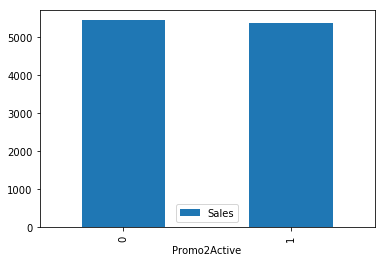

In [21]:
train[train.Promo2 == 1].groupby("Promo2Active").agg({"Sales": "mean"}).plot(kind="bar")

It's funny that mean daily sales are even a tiny bit lower with Promo2 active.

##### Sales vs CompetitionActive

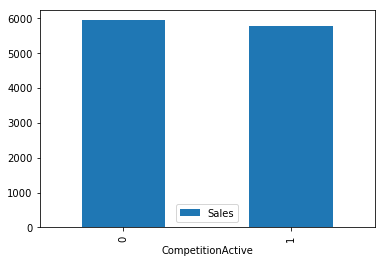

In [22]:
train.groupby("CompetitionActive").agg({"Sales": "mean"}).plot(kind="bar")

Competition nearby predictably lowers mean daily sales, but not much.

### Data Munging

In [23]:
# we already have these, but for the sake of consistence, let's do it again
train = df_train.merge(df_store)
test = df_test.merge(df_store)

train["Promo2Active"] = get_Promo2Active(train)
train["CompetitionActive"] = get_CompetitionActive(train)

test["Promo2Active"] = get_Promo2Active(test)
test["CompetitionActive"] = get_CompetitionActive(test)

Holidays are seasonal, so it could be helpful to have DayOfYear feature.

In [24]:
train["DayOfYear"] = train.Date.apply(lambda x: x.timetuple().tm_yday)
test["DayOfYear"] = test.Date.apply(lambda x: x.timetuple().tm_yday)

Also, let's convert every date to a day, where day 0 == min date...

In [25]:
min_date = train.Date.min() # we know that all test data happened later
def date_to_day_number(df):
    return (df.Date - min_date).apply(lambda x: x.days)

In [26]:
train["Day"] = date_to_day_number(train)
test["Day"] = date_to_day_number(test)

... and sort by Day.

In [27]:
train.sort_values("Day", inplace=True)
test.sort_values("Day", inplace=True)

### Model

In [28]:
def rmspe(y_true, y_pred):
    w = np.zeros(y_true.shape, dtype=float)
    ind = y_true != 0
    w[ind] = 1./ (y_true[ind]**2)
    return np.sqrt(np.mean(w * (y_true - y_pred)**2))
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

##### Baseline

In [29]:
train_baseline = train.copy()
train_baseline['Last_Week_Sales'] = train_baseline.groupby("Store")["Sales"].shift()
train_baseline['Last_Week_Diff'] = train_baseline.groupby("Store")["Last_Week_Sales"].diff()
train_baseline.dropna(inplace=True, subset=["Last_Week_Sales", "Last_Week_Diff"])
train_baseline.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Promo2Active,CompetitionActive,DayOfYear,Day,Last_Week_Sales,Last_Week_Diff
413475,453,4,2013-01-03,6109,740,1,0,0,1,a,...,0,NaN,NaN,NaN,0,1,3,2,8265.0,8265.0
276245,304,4,2013-01-03,5457,893,1,0,0,1,a,...,0,NaN,NaN,NaN,0,0,3,2,7108.0,7108.0
145197,160,4,2013-01-03,5068,523,1,0,0,1,d,...,0,NaN,NaN,NaN,0,1,3,2,5726.0,5726.0
515483,565,4,2013-01-03,5262,645,1,0,0,1,a,...,0,NaN,NaN,NaN,0,1,3,2,5856.0,5856.0
648253,712,4,2013-01-03,6250,566,1,0,0,1,a,...,1,45.0,2009.0,"Jan,Apr,Jul,Oct",1,1,3,2,6377.0,6377.0


In [30]:
mean_error = []
for day in range(2, train_baseline.Day.max() + 1):
    val = train_baseline[train_baseline.Day == day]
    p = val.Last_Week_Sales.values
    error = rmspe(val.Sales.values, p)
    mean_error.append(error)
    
print('Mean Error = %.5f' % np.mean(mean_error))

Mean Error = 0.36051


##### Basic model

Let's forget for a minute that we are dealing with time series here and try to use the usual approach.

In [31]:
class LabelEncoderPipelineFriendly(LabelEncoder):
    
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)

In [32]:
def prepare_pipeline(df):
    
    def get_DayOfWeek(df):
        return df["DayOfWeek"]
    
    def get_Open(df):
        return df[["Open"]]
    
    def get_Promo(df):
        return df[["Promo"]]
    
    def get_StateHoliday(df):
        return df["StateHoliday"]
    
    def get_SchoolHoliday(df):
        return df[["SchoolHoliday"]]
    
    def get_StoreType(df):
        return df["StoreType"]
    
    def get_Assortment(df):
        return df["Assortment"]
    
    def get_Promo2Active(df):
        return df[["Promo2Active"]]
    
    def get_CompetitionActive(df):
        return df[["CompetitionActive"]]
    
    def get_CompetitionDistance(df):
        return df[["CompetitionDistance"]]
    
    def get_DayOfYear(df):
        return df["DayOfYear"]
    
    p = make_union(*[
        make_pipeline(FunctionTransformer(get_DayOfWeek, validate=False), 
                      LabelEncoderPipelineFriendly(), 
                      OneHotEncoder()),
        make_pipeline(FunctionTransformer(get_Open, validate=False),
                      Imputer(strategy="most_frequent")),
        make_pipeline(FunctionTransformer(get_Promo, validate=False)),
        make_pipeline(FunctionTransformer(get_StateHoliday, validate=False), 
                      LabelEncoderPipelineFriendly(), 
                      OneHotEncoder()),
        make_pipeline(FunctionTransformer(get_SchoolHoliday, validate=False)),
        make_pipeline(FunctionTransformer(get_StoreType, validate=False),
                      LabelEncoderPipelineFriendly(), 
                      OneHotEncoder()),
        make_pipeline(FunctionTransformer(get_Assortment, validate=False),
                      LabelEncoderPipelineFriendly(), 
                      OneHotEncoder()),
        make_pipeline(FunctionTransformer(get_Promo2Active, validate=False)),
        make_pipeline(FunctionTransformer(get_CompetitionActive, validate=False)),
        make_pipeline(FunctionTransformer(get_CompetitionDistance, validate=False),
                      Imputer(),
                      StandardScaler()),        
        make_pipeline(FunctionTransformer(get_DayOfYear, validate=False),
                      LabelEncoderPipelineFriendly(), 
                      OneHotEncoder())
    ])
    
    return p

In [33]:
pipeline = prepare_pipeline(train)

In [34]:
x_train, y_train = pipeline.fit_transform(train), train.Sales
x_test = pipeline.transform(test)

In [35]:
params = {"boosting_type" : ["gbdt"],
          "learning_rate": [0.1],
          "n_estimators": [200],
          "objective": ["regression"],
          "reg_alpha": [0.0, 0.5, 1.0],
          "reg_lambda": [0.0, 0.5, 1.0],
          "random_state": [0],
          "n_jobs": [-1]
         }

In [36]:
gs = GridSearchCV(LGBMRegressor(), params, scoring=rmspe_scorer, cv=10, n_jobs=-1)
gs.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
       max_bin=255, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0.0, n_estimators=10, n_jobs=-1, num_leaves=31,
       objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=50000,
       subsample_freq=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'boosting_type': ['gbdt'], 'learning_rate': [0.1], 'n_estimators': [200], 'objective': ['regression'], 'reg_alpha': [0.0, 0.5, 1.0], 'reg_lambda': [0.0, 0.5, 1.0], 'random_state': [0], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmspe, greater_is_better=False), verbose=0)

In [37]:
prediction = gs.predict(x_test)

In [38]:
pd.DataFrame({"Id": test.Id, "Sales": prediction}).to_csv("submission.csv", sep=",", index=False)

##### Time-series aware model

We have 941 days of consecutive sales data and we need to predict just 47 days of sales.  
One way to do this is to train a model on a dataset, that contains sales data for days up to the day we are predicting, i.e. the last day of a training dataset is the day before the day in question. But this approach could be not too convenient, as we need to add previous predictions to the train data as we go.  
Instead, assuming there're repeating patterns in data, we could train the model in a such way, that it predicts sales for the day D+48, where D is the last day of training data.

In [39]:
def prepare_pipeline_ts(df, min_shift, max_shift):
    
    def get_shifted_date(df, for_sales=False):
        return (df.Date.min() + pd.DateOffset(days_to_shift))
    
    def get_DayOfWeek(df):
        return df["DayOfWeek"]
    
    def get_Open(df):
        return df[["Open"]]
    
    def get_Promo(df):
        return df[["Promo"]]
    
    def get_StateHoliday(df):
        return df["StateHoliday"]
    
    def get_SchoolHoliday(df):
        return df[["SchoolHoliday"]]
    
    def get_StoreType(df):
        return df["StoreType"]
    
    def get_Assortment(df):
        return df["Assortment"]
    
    def get_Promo2Active(df):
        return df[["Promo2Active"]]
    
    def get_CompetitionActive(df):
        return df[["CompetitionActive"]]
    
    def get_CompetitionDistance(df):
        return df[["CompetitionDistance"]]
    
    def get_DayOfYear(df):
        return df["DayOfYear"]
    
    def get_previous_sales(df):
        sales = df[["Store", "Sales"]].copy()
        for day in range(min_shift, max_shift + 1):
            sales["Last-{}_Day_Sales".format(day)] = sales.groupby("Store")["Sales"].shift(day)
            sales["Last-{}_Day_Diff".format(day)] = sales.groupby("Store")["Last-{}_Day_Sales".format(day)].diff()
        
        return sales.drop(["Store", "Sales"], axis=1)
    
    p = make_union(*[
        make_pipeline(FunctionTransformer(get_DayOfWeek, validate=False), 
                      LabelEncoderPipelineFriendly(), 
                      OneHotEncoder()),
        make_pipeline(FunctionTransformer(get_Open, validate=False),
                      Imputer(strategy="most_frequent")),
        make_pipeline(FunctionTransformer(get_Promo, validate=False)),
        make_pipeline(FunctionTransformer(get_StateHoliday, validate=False), 
                      LabelEncoderPipelineFriendly(), 
                      OneHotEncoder()),
        make_pipeline(FunctionTransformer(get_SchoolHoliday, validate=False)),
        make_pipeline(FunctionTransformer(get_StoreType, validate=False),
                      LabelEncoderPipelineFriendly(), 
                      OneHotEncoder()),
        make_pipeline(FunctionTransformer(get_Assortment, validate=False),
                      LabelEncoderPipelineFriendly(), 
                      OneHotEncoder()),
        make_pipeline(FunctionTransformer(get_Promo2Active, validate=False)),
        make_pipeline(FunctionTransformer(get_CompetitionActive, validate=False)),
        make_pipeline(FunctionTransformer(get_CompetitionDistance, validate=False),
                      Imputer(),
                      StandardScaler()),        
        make_pipeline(FunctionTransformer(get_DayOfYear, validate=False),
                      LabelEncoderPipelineFriendly(), 
                      OneHotEncoder()),
        make_pipeline(FunctionTransformer(get_previous_sales, validate=False), 
                      Imputer(),
                      StandardScaler())
    ])
    
    return p

In [40]:
test_size = len(test)
min_shift = (test.Date.max() - test.Date.min()).days 
max_shift = 180
to_drop = len(train[train.Date < train.Date.min() + pd.DateOffset(max_shift)])

In [41]:
full = pd.concat([train, test], ignore_index=True) # we need to use full dataset to fill previous sales for test
pipeline_ts = prepare_pipeline_ts(train, min_shift, max_shift)
full_transformed = pipeline_ts.fit_transform(full)
x_train_ts, y_train_ts = full_transformed[to_drop:-test_size], train.Sales[to_drop:]
x_test_ts = full_transformed[-test_size:]

In [42]:
gs_ts = GridSearchCV(LGBMRegressor(), params, scoring=rmspe_scorer, cv=10, n_jobs=2)
gs_ts.fit(x_train_ts, y_train_ts)

GridSearchCV(cv=10, error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
       max_bin=255, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0.0, n_estimators=10, n_jobs=-1, num_leaves=31,
       objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=50000,
       subsample_freq=1),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'boosting_type': ['gbdt'], 'learning_rate': [0.1], 'n_estimators': [200], 'objective': ['regression'], 'reg_alpha': [0.0, 0.5, 1.0], 'reg_lambda': [0.0, 0.5, 1.0], 'random_state': [0], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmspe, greater_is_better=False), verbose=0)

In [43]:
prediction_ts = gs_ts.predict(x_test_ts)

In [44]:
pd.DataFrame({"Id": test.Id, "Sales": prediction_ts}).to_csv("submission_ts.csv", sep=",", index=False)